In [2]:
# import pyrosm
# from pyrosm import get_data, OSM
# import numpy as np
# import pandas as pd

# from shapely.geometry import LineString, Polygon, Point


# from pyproj import Transformer
# from shapely.geometry import Polygon


# # ********************************


# """ ***In diesem Skript werden Charakteristika der Umgebung eines Tracks berechnet.***
# Bodenbeschaffenheit und Highway (verwendet für Verkehr), Natur, Urban, Wasser, Kultur und Wald werdenaus einem lokal gespeicherten pbf File mithilfe der library pyrosm gelesen.***
# --> Für surface, highway, urban via buildings werden Funktionen von pyrosm genutzt, für alle anderen auch aber mit custom_filter, die in dem Skript osm_dicts() zu finden sind
#  Vorgehensweise: Es wird einerseits eine Fläche erstellt aus dem ganzen Track inkl. Buffer Zone (default 50m) 
# - in dieser "Bounding Box" werden dann die OSM-Daten zu Straßennetzwerken vom gedownloadeten File abgefragt mit der Funktion
# osm.get_networks() von der pyrosm library. Außerdem wird eine Liste gemacht mit 5m Radius Buffer Zonen um jeden Punkt des Tracks.
# die Funktion osm.get_networks() returned einen GeoDataFrame mit den Straßennetzwerken, darunter auch Infos zur Bodenbeschaffenheit. 
# Die Infos zur Bodenbeschaffenheit werden in MultiLineStrings zurückgegeben. Es wird dann in add_surfaces_to_track() für jeden Punkt des Tracks geschaut
# ob sich der Punkt inkl. Puffer mit dem MultiLineString überschneidet und wenn ja, wird die Bodenbeschaffenheit für die Koordinate übernommen. 


# NOTE: Diese Logik wurde neu implementiert und es muss noch getestet werden, wie gut sie funktioniert und speziell welche Issues durch die Berechnung mittels shapely Geometrieobjeten anfallen.
# z.B. bekommt man manchmal den Error: 

# Incorrect geometry type in index position 95 of track. Skipping.
# 26.02.2024 9:39:39
# 'waterway'
# 26.02.2024 9:39:39
# Incorrect geometry type in index position 96 of track. Skipping.
# 26.02.2024 9:39:39
# 'waterway'
# 26.02.2024 9:39:39
# Incorrect geometry type in index position 97 of track. Skipping.
# 26.02.2024 9:39:39
# 'waterway' 


# bzw. 

#  track, traffic, water, forest, urban, nature, culture = way_metadata_from_coordinates(payload["object"]["track"])
# 26.02.2024 12:44:52
#   File "/code/app/section/osm_queries.py", line 175, in way_metadata_from_coordinates
# 26.02.2024 12:44:52
#     nature = get_nature(track, osm, bounding_box)
# 26.02.2024 12:44:52
#   File "/code/app/section/osm_section_info_pyrosm.py", line 258, in get_nature
# 26.02.2024 12:44:52
#     custom_nature = osm.get_data_by_custom_criteria(custom_filter=nature_dict)
# 26.02.2024 12:44:52
#   File "/usr/local/lib/python3.9/site-packages/pyrosm/pyrosm.py", line 767, in get_data_by_custom_criteria
# 26.02.2024 12:44:52
#     gdf = get_user_defined_data(
# 26.02.2024 12:44:52
#   File "/usr/local/lib/python3.9/site-packages/pyrosm/user_defined.py", line 58, in get_user_defined_data
# gdf = prepare_geodataframe(
# 26.02.2024 12:44:52
#   File "pyrosm/frames.pyx", line 136, in pyrosm.frames.prepare_geodataframe
# 26.02.2024 12:44:52
#   File "pyrosm/frames.pyx", line 149, in pyrosm.frames.prepare_geodataframe
# 26.02.2024 12:44:52
#   File "pyrosm/frames.pyx", line 129, in pyrosm.frames.prepare_relation_gdf
# 26.02.2024 12:44:52
#   File "/usr/local/lib/python3.9/site-packages/geopandas/geodataframe.py", line 151, in __init__
# 26.02.2024 12:44:52
#     if crs is not None and data.crs != crs:
# 26.02.2024 12:44:52
#   File "/usr/local/lib/python3.9/site-packages/pandas/core/generic.py", line 6293, in __getattr__
# 26.02.2024 12:44:52
#     return object.__getattribute__(self, name)
# 26.02.2024 12:44:52
#   File "/usr/local/lib/python3.9/site-packages/geopandas/geodataframe.py", line 439, in crs
# 26.02.2024 12:44:52
#     raise AttributeError(
# AttributeError: The CRS attribute of a GeoDataFrame without an active geometry column is not defined. Use GeoDataFrame.set_geometry to set the active geometry column.



# --> Es gehört ggf. gecheckt was diese Fehler auslöst anstatt sie nur zu handlen.

# NOTE 2.0: Test Cases noch nicht implementiert """


# # def osm_dicts():
# #     water_dict = {"natural":["water"],
# #                     "water":["river", "stream", "canal", "lake", "cenote", "lagoon", "oxbow", "rapids", "stream_pool", "harbour", "lock", "pond", "reservoir"],
# #                     "waterway":["river", "stream", "tidal_channel", "canal", "fairway", "dam", "waterfall", "rapids"]}

# #     forest_dict = {"landuse":["forest"]}

# #     nature_dict = {"landuse": ["grass", "forest", "farmland", "orchard", "meadow"],
# #                         "leisure":["park", "garden"],
# #                         "natural":["water", "heath", "scrub", "tree", "tree_row", "plain", "grassland", "shrubbery", "wood", "bay", "beach", "coastline", "glacier", "cliff", "dune", "valley"]}

# #     urban_dict = {"admin_level":["8", "9"]}

# #     culture_dict = {
# #     "tourism": ["museum", "artwork", "gallery", "attraction", "information", "viewpoint", "picnic_site", "theme_park", "zoo", "aquarium", "botanical_garden", "winery", "vineyard", "historic_site", "memorial", "monument", "archaeological_site", "fort", "castle", "ruins", "church", "mosque", "temple", "synagogue", "cathedral"],
# #     "amenity": ["theatre", "library", "place_of_worship", "community_centre", "arts_centre", "cinema", "music_venue", "nightclub", "social_centre", "events_venue", "gallery", "studio", "cultural_centre", "youth_centre"],
# #     "artwork": ["statue", "sculpture", "mural", "street_art"],
# #     "historic": ["memorial", "monument", "archaeological_site", "fort", "castle", "ruins"],
# #     "festival": ["art", "music", "food", "cultural"],
# #     "museum": ["art", "history", "science", "natural_history", "maritime", "aviation", "war", "archaeology", "ethnology", "folklore", "local_history", "biography", "children", "technology"],
# #     "library": ["public", "academic", "special"],
# #     "theatre": ["performing_arts", "dance", "drama", "music", "opera", "ballet"],
# #     "place_of_worship": ["christian", "muslim", "jewish", "hindu", "buddhist", "sikh", "shinto", "taoist", "bahai", "jain"],
# #     "street_art": ["mural", "graffiti", "stencil", "installation"]}


# #     return water_dict, forest_dict, nature_dict, urban_dict, culture_dict


# def track_2_latlon_dict(track):
#     lat_lon_dict = {}
#     keys = []

#     for nr, position in enumerate(track):
#         pos_nr = f"point{nr}"
#         keys.append(pos_nr)
#         lat_lon_dict[pos_nr] = (position["lat"], position["lon"])

#     return lat_lon_dict


# def lat_lon_to_linestring(track):
#     # Extract latitudes and longitudes from the dictionary
#     lat_lon_dict = track_2_latlon_dict(track)
#     coordinates = [(lon, lat) for lat, lon in lat_lon_dict.values()]
#     # Create a LineString from the coordinates
#     return LineString(coordinates)


# def lat_lon_to_point(lat_lon_dict_element):
#     return Point(lat_lon_dict_element[1], lat_lon_dict_element[0])


# def create_bounding_box(line, buffer_distance):
#     # Create a buffer around the line
#     buffer_shape = line.buffer(buffer_distance)

#     # Convert polygon to a Polygon
#     if isinstance(buffer_shape, Polygon):
#         return buffer_shape
#     else:
#         # If the buffer_shape simplifies to a MultiPolygon, take its exterior
#         return Polygon(buffer_shape.exterior)


# def point_2_buffer(lat_lon_dict_element, buffer_distance=0.000045):  # approx 5m
#     point = lat_lon_to_point(lat_lon_dict_element)
#     bounding_box = create_bounding_box(point, buffer_distance)
#     return bounding_box


# def track_2_buffer(lat_lon_dict, buffer_distance=0.00045):  # approx 50m
#     line_string = lat_lon_to_linestring(lat_lon_dict)
#     bounding_box = create_bounding_box(line_string, buffer_distance)
#     line_string_list = list(line_string.coords)
#     point_objects = [Point(coords) for coords in line_string_list]
#     point_objects_with_buffer = [
#         point_2_buffer((coords[1], coords[0])) for coords in line_string_list
#     ]
#     point_objects_with_buffer_water = [
#         point_2_buffer((coords[1], coords[0]), 0.0009) for coords in line_string_list
#     ]

#     return (
#         bounding_box,
#         point_objects_with_buffer,
#         point_objects_with_buffer_water,
#         line_string,
#     )


# def preprocessing_for_pyrosm_extraction(track, buffer=0.00045):  # 50m
#     bounding_box, track_point_objects, track_point_objects_water, linestring_track = (
#         track_2_buffer(track, buffer)
#     )
#     # fp = "/osmfile/steiermark.osm.pbf" # this is the download link for the file: https://download.openstreetmap.fr/extracts/europe/austria/steiermark.osm.pbf
#     fp = get_data("Austria")  # update = True
#     osm = pyrosm.OSM(fp, bounding_box=bounding_box)
#     return (
#         osm,
#         bounding_box,
#         track_point_objects,
#         track_point_objects_water,
#         linestring_track,
#     )


# # up until here are preprocessing steps relevant for all categories
# ####################################################################


# def get_forest(track, osm, bounding_box):
#     # osm, bounding_box, track_point_objects, linestring_track = preprocessing_for_pyrosm_extraction(track)
#     forest_dict = osm_dicts()[1]
#     custom_forest = osm.get_data_by_custom_criteria(custom_filter=forest_dict)
#     try:
#         custom_forest.loc[custom_forest["osm_type"] == "node", "geometry"] = (
#             custom_forest.loc[
#                 custom_forest["osm_type"] == "node", "geometry"
#             ].apply(lambda geom: geom.buffer(0.0000253))
#         )  # 2m
#         forest_density = get_area_percentage_of_category(bounding_box, custom_forest)
#         print(f"forest density successfully calculated: {forest_density}")
#         return forest_density
#     except AttributeError:
#         print("No forest found")
#         return 0


# def get_nature(track, osm, bounding_box):
#     # osm, bounding_box, track_point_objects, linestring_track = preprocessing_for_pyrosm_extraction(track)
#     nature_dict = osm_dicts()[2]
#     custom_nature = osm.get_data_by_custom_criteria(custom_filter=nature_dict)

#     try:
#         custom_nature.loc[custom_nature["osm_type"] == "node", "geometry"] = (
#             custom_nature.loc[
#                 custom_nature["osm_type"] == "node", "geometry"
#             ].apply(lambda geom: geom.buffer(0.0000253))
#         )  # 2m
#         nature_density = get_area_percentage_of_category(bounding_box, custom_nature)
#         print(f"nature density successfully calculated: {nature_density}")
#         return nature_density
#     except AttributeError:
#         print("No nature found")
#         return 0


# def get_culture(track, osm, bounding_box):
#     # osm, bounding_box, track_point_objects, linestring_track = preprocessing_for_pyrosm_extraction(track)
#     culture_dict = osm_dicts()[4]
#     custom_culture = osm.get_data_by_custom_criteria(custom_filter=culture_dict)
#     try:
#         custom_culture.loc[custom_culture["osm_type"] == "node", "geometry"] = (
#             custom_culture.loc[
#                 custom_culture["osm_type"] == "node", "geometry"
#             ].apply(lambda geom: geom.buffer(0.0000253))
#         )  # 2m
#         culture_density = get_area_percentage_of_category(bounding_box, custom_culture)
#         print(f"culture density successfully calculated: {culture_density}")
#         return culture_density
#     except AttributeError:
#         print("No culture found")
#         return 0







In [3]:
import pyrosm
from pyrosm import get_data, OSM
import numpy as np
import pandas as pd

from shapely.geometry import LineString, Polygon, Point


from pyproj import Transformer
from shapely.geometry import Polygon

In [4]:
fp = get_data("Tokyo", directory="foursquaretky_dataset")  # update = True

In [5]:
osm = pyrosm.OSM(fp)

In [6]:
osm

In [7]:
# def lat_lon_to_point(lat_lon_dict_element):
#     return Point(lat_lon_dict_element[1], lat_lon_dict_element[0])


# def create_bounding_box(line, buffer_distance):
#     # Create a buffer around the line
#     buffer_shape = line.buffer(buffer_distance)

#     # Convert polygon to a Polygon
#     if isinstance(buffer_shape, Polygon):
#         return buffer_shape
#     else:
#         # If the buffer_shape simplifies to a MultiPolygon, take its exterior
#         return Polygon(buffer_shape.exterior)

# def point_2_buffer(lat_lon_dict_element, buffer_distance=0.000045):  # approx 5m
#     point = lat_lon_to_point(lat_lon_dict_element)
#     bounding_box = create_bounding_box(point, buffer_distance)
#     return bounding_box


def preprocessing_for_pyrosm_extraction(fp, coords, buffer=0.0045):  # 500m
    bounding_box = (
        point_2_buffer(coords, buffer)
    )


    bbox_geom = bounding_box['geometry'].values[0]

    # Initiliaze with bounding box
    osm = OSM(fp, bounding_box=bbox_geom)
    return osm, bounding_box


def lat_lon_to_point(lat_lon_dict_element):
    return Point(lat_lon_dict_element)  # If already Point, return it as is

def create_bounding_box(point, buffer_distance):
    return point.buffer(buffer_distance)  # Creates a circular buffer

def point_2_buffer(point, buffer_distance=0.000045):  # Approx 5m
    bounding_box = create_bounding_box(point, buffer_distance)
    return bounding_box

In [8]:
from globals import BASE_DIR
import geopandas as gpd
dataset = "foursquaretky"

In [9]:
df = pd.read_csv(f"{BASE_DIR }{dataset}_dataset/processed_data_recbole/{dataset}_sample.item", sep="\t")

In [10]:
df['geometry'] = df.apply(lambda row: Point(row['lon:float'], row['lat:float']), axis=1)

# Convert to GeoDataFrame
pois = gpd.GeoDataFrame(df, geometry='geometry')

# Set a CRS (Coordinate Reference System) - use EPSG:4326 for WGS84
pois.set_crs(epsg=4326, inplace=True)

,item_id:token,category_id:token,category_name:token_seq,lat:float,lon:float,geometry
0,156_x,4bf58dd8d48988d129951735,Train Station,35.700253,139.480255,POINT (139.48025 35.70025)
1,431_x,4bf58dd8d48988d1eb931735,Airport,35.548963,139.784611,POINT (139.78461 35.54896)
2,1031_x,4bf58dd8d48988d1df941735,Bridge,35.609929,139.825659,POINT (139.82566 35.60993)
3,1428_x,4bf58dd8d48988d129951735,Train Station,35.749538,139.586540,POINT (139.58654 35.74954)
4,184_x,4bf58dd8d48988d129951735,Train Station,35.729025,139.711096,POINT (139.7111 35.72903)
...,...,...,...,...,...,...
2799,1509_x,4bf58dd8d48988d120941735,Bar,35.697700,139.770384,POINT (139.77038 35.6977)
2800,1467_x,4bf58dd8d48988d16d941735,Café,35.702436,139.770470,POINT (139.77047 35.70244)
2801,1440_x,4bf58dd8d48988d129951735,Train Station,35.607054,139.734894,POINT (139.73489 35.60705)
2802,2582_x,4d954b0ea243a5684a65b473,Convenience Store,35.701178,139.771038,POINT (139.77104 35.70118)


In [11]:
pois['geometry'] = pois['geometry'].apply(lambda point: point_2_buffer(point))


In [12]:
pois

,item_id:token,category_id:token,category_name:token_seq,lat:float,lon:float,geometry
0,156_x,4bf58dd8d48988d129951735,Train Station,35.700253,139.480255,"POLYGON ((139.4803 35.70025, 139.4803 35.70025..."
1,431_x,4bf58dd8d48988d1eb931735,Airport,35.548963,139.784611,"POLYGON ((139.78466 35.54896, 139.78466 35.548..."
2,1031_x,4bf58dd8d48988d1df941735,Bridge,35.609929,139.825659,"POLYGON ((139.8257 35.60993, 139.8257 35.60993..."
3,1428_x,4bf58dd8d48988d129951735,Train Station,35.749538,139.586540,"POLYGON ((139.58658 35.74954, 139.58658 35.749..."
4,184_x,4bf58dd8d48988d129951735,Train Station,35.729025,139.711096,"POLYGON ((139.71114 35.72903, 139.71114 35.729..."
...,...,...,...,...,...,...
2799,1509_x,4bf58dd8d48988d120941735,Bar,35.697700,139.770384,"POLYGON ((139.77043 35.6977, 139.77043 35.6977..."
2800,1467_x,4bf58dd8d48988d16d941735,Café,35.702436,139.770470,"POLYGON ((139.77052 35.70244, 139.77051 35.702..."
2801,1440_x,4bf58dd8d48988d129951735,Train Station,35.607054,139.734894,"POLYGON ((139.73494 35.60705, 139.73494 35.607..."
2802,2582_x,4d954b0ea243a5684a65b473,Convenience Store,35.701178,139.771038,"POLYGON ((139.77108 35.70118, 139.77108 35.701..."


In [13]:
pois = pois.loc[pois["category_name:token_seq"] == "Arcade"]

In [14]:
# Load the Pyrosm OSM dataset (replace with the relevant .pbf file)
osm_data_path = "/path/to/tokyo-latest.osm.pbf"
osm = pyrosm.OSM(fp)

# Function to extract points within a polygon
def extract_osm_points(polygon, osm_object):
    # Extract POIs (amenities, places, etc.)
    pois_osm = osm_object.get_pois()
    
    # Filter POIs that intersect with the polygon
    pois_within_polygon = pois_osm[pois_osm.geometry.intersects(polygon)]
    return pois_within_polygon

# Apply the function to each row's polygon
osm_results = []
for idx, row in pois.iterrows():
    polygon = row.geometry
    pois_osm = extract_osm_points(polygon, osm)
    print(pois_osm)
    osm_results.append({"item_id": row.item_id, "osm_pois": pois})

# Create a results DataFrame
results_df = pd.DataFrame(osm_results)

# Inspect the results
print(results_df)

                                                     tags  changeset visible  \
34191   {"name:ja":"\uFF20\u307B\u3049\uFF5E\u3080\u30...        0.0   False   
103529  {"addr:block_number":"3","addr:city:en":"Chiyo...        NaN   False   

               lon  timestamp  version          id        lat addr:city  \
34191   139.771881          0        0  4235062290  35.700741      None   
103529         NaN          0        0    89182734        NaN      千代田区   

       addr:country  ... information museum tourism   zoo  \
34191          None  ...        None   None    None  None   
103529         None  ...        None   None    None  None   

                                                 geometry osm_type  fuel  \
34191                          POINT (139.77188 35.70074)     node   NaN   
103529  POLYGON ((139.77174 35.70089, 139.77203 35.700...      way  None   

        taxi theatre water  
34191    NaN     NaN   NaN  
103529  None    None  None  

[2 rows x 92 columns]


AttributeError: 'Series' object has no attribute 'item_id'

In [162]:
osm, bounding_box = preprocessing_for_pyrosm_extraction(fp, coords)

TypeError: 'Polygon' object is not subscriptable

In [ ]:
custom_filter = {'amenity': True, "shop": True}
all_pois_location = osm.get_pois(custom_filter=custom_filter)

all_pois_location["poi_type"] = all_pois_location["amenity"]
all_pois_location["poi_type"] = all_pois_location["poi_type"].fillna(all_pois_location["shop"])

/Users/andreaforster/dev/thesis/preprocessing/prep_venv/lib/python3.11/site-packages/geopandas/plotting.py:956: UserWarning: Glyph 12521 (\N{KATAKANA LETTER RA}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/Users/andreaforster/dev/thesis/preprocessing/prep_venv/lib/python3.11/site-packages/geopandas/plotting.py:956: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/Users/andreaforster/dev/thesis/preprocessing/prep_venv/lib/python3.11/site-packages/geopandas/plotting.py:956: UserWarning: Glyph 12513 (\N{KATAKANA LETTER ME}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/Users/andreaforster/dev/thesis/preprocessing/prep_venv/lib/python3.11/site-packages/geopandas/plotting.py:956: UserWarning: Glyph 12531 (\N{KATAKANA LETTER N}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/Users/andreaforster/dev/thesis/preprocessing/prep_venv/lib/python3.11/si

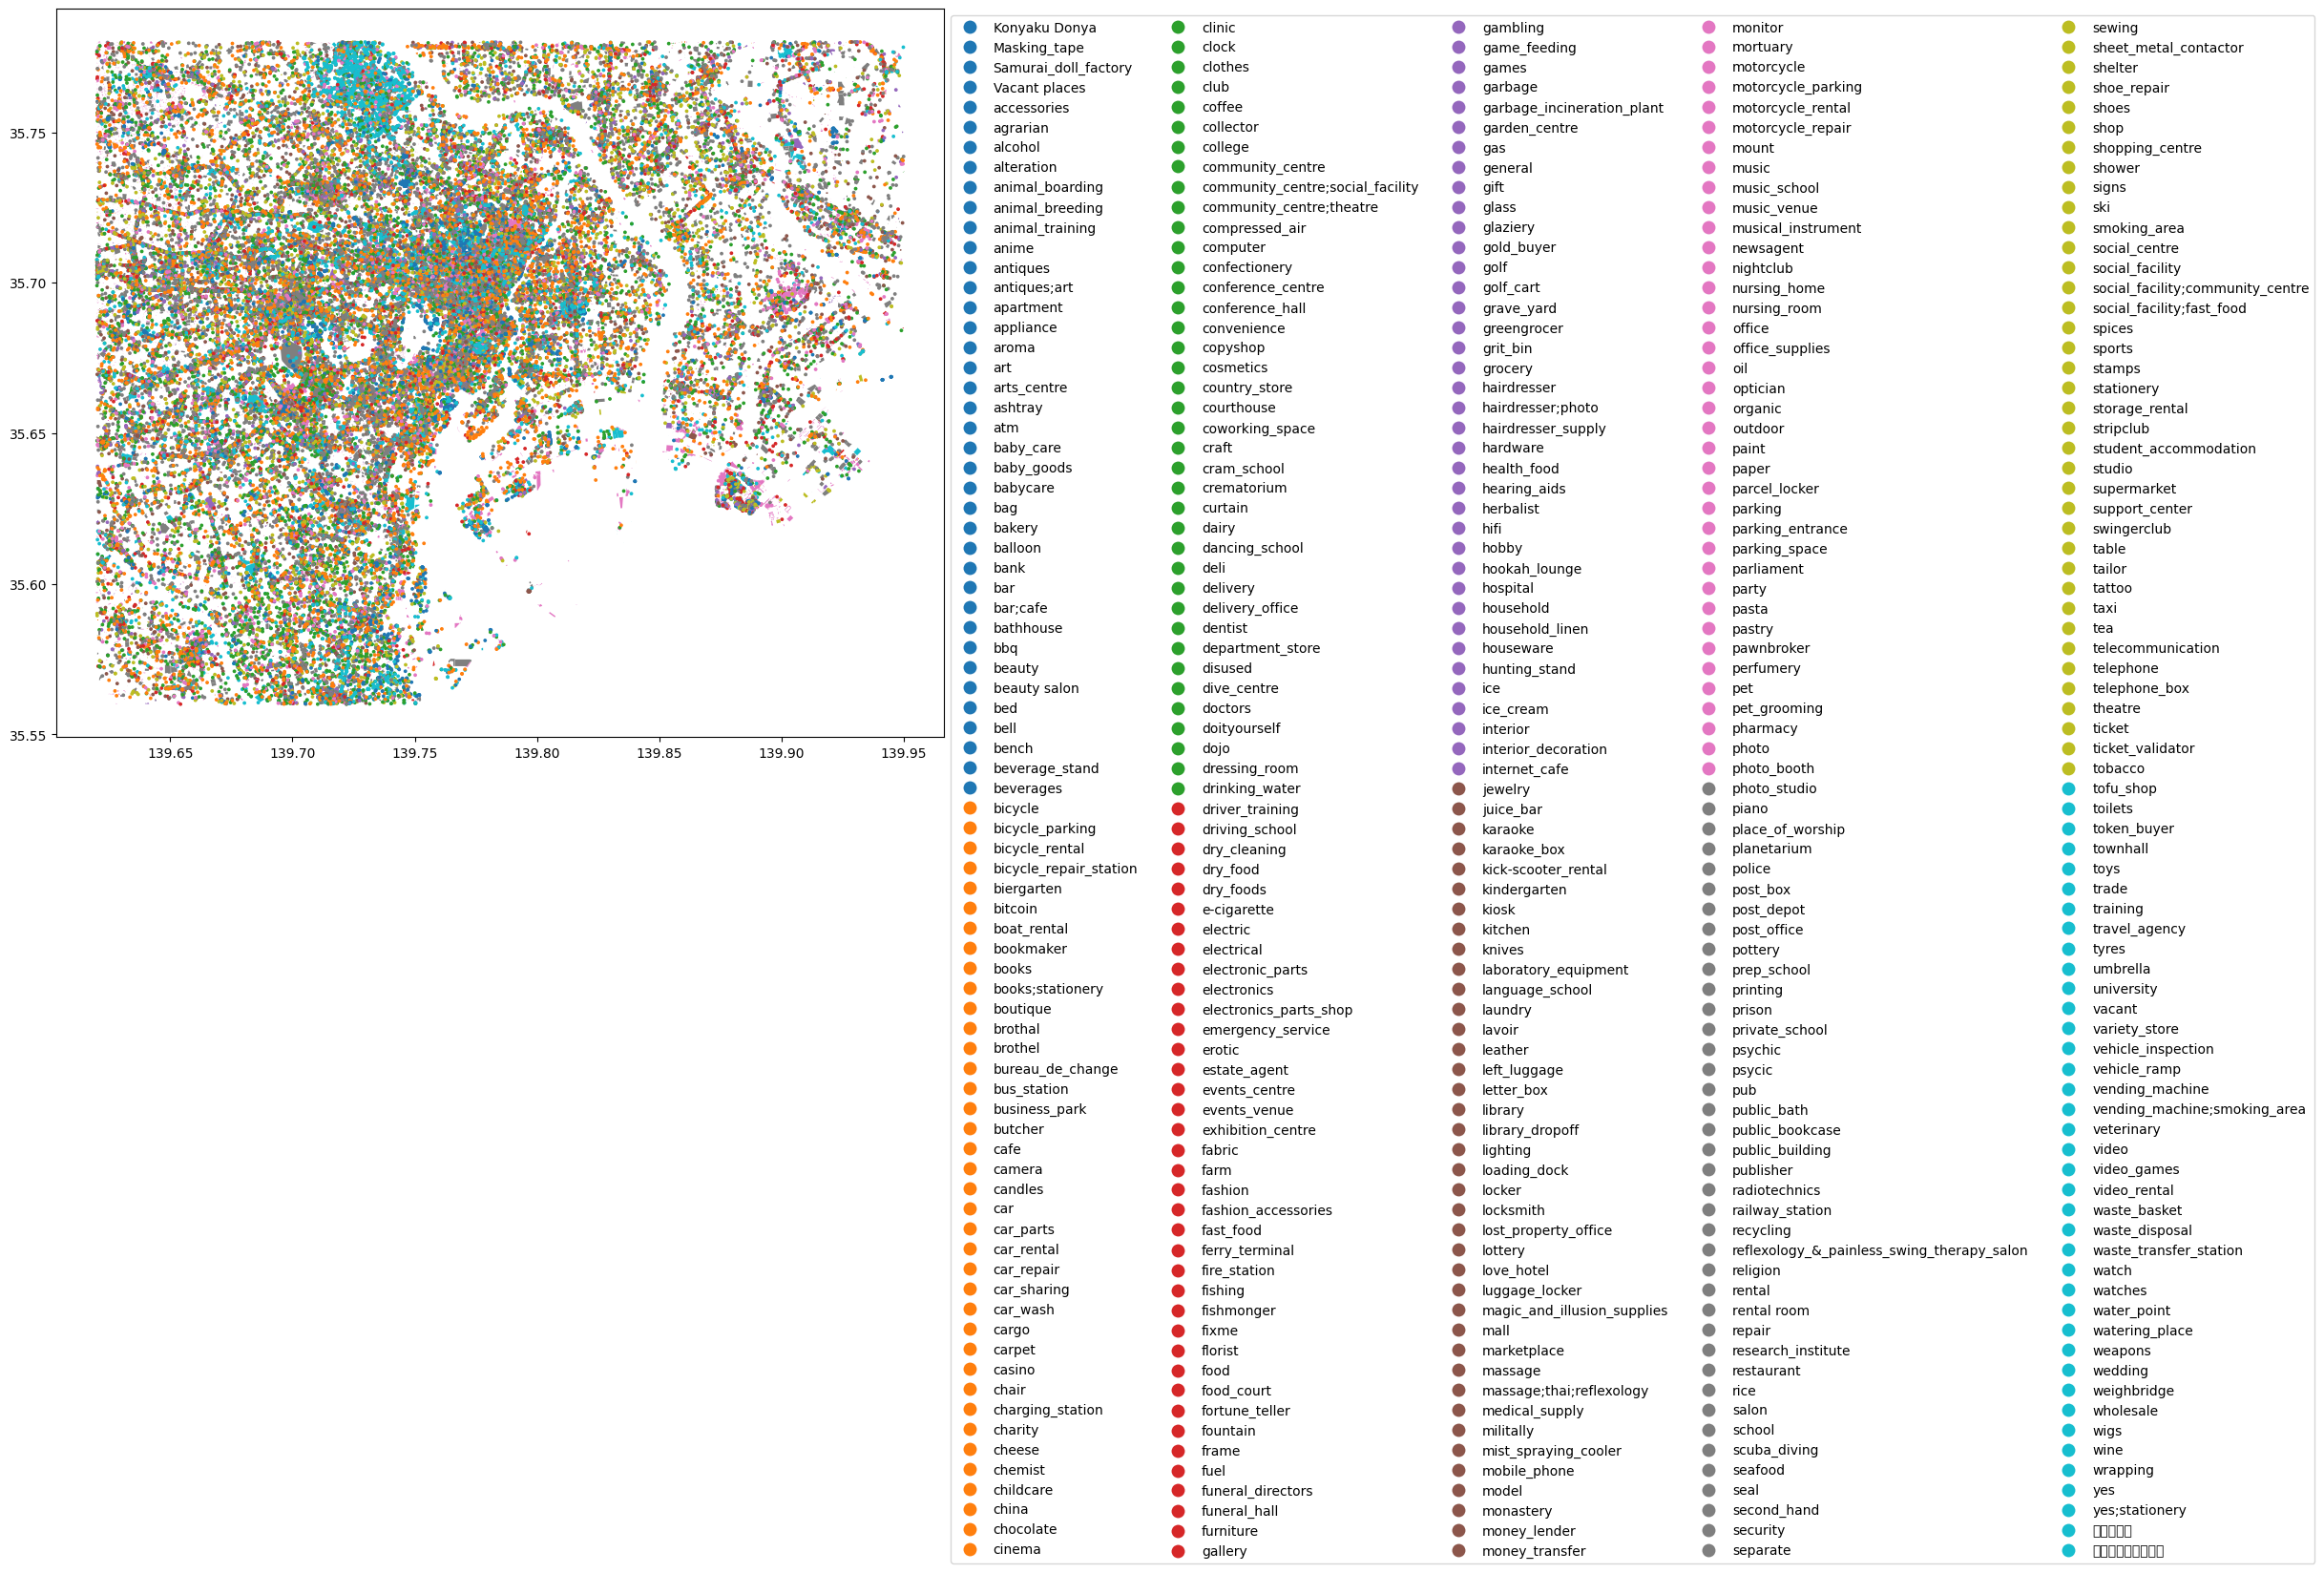

In [ ]:
ax = all_pois_location.plot(column='poi_type', markersize=3, figsize=(12,12), legend=True, legend_kwds=dict(loc='upper left', ncol=5, bbox_to_anchor=(1, 1)))